## Call dependencies

In [1]:
import pandas as pd
import talib

from matplotlib import pyplot as plt
from mpl_finance import candlestick2_ohlc, candlestick_ohlc
import matplotlib.dates as mdates

## Load Sample data

In [3]:
from utilities import Utilities
from config import *
util = Utilities()
engine = util.set_db_engine(DB_ID,DB_PWD,DB_IP,DB_PORT,DB_NAME)
query= "select * from `a005930` where `bdate` >= '2018-01-01';"
data = pd.read_sql(sql=query, con=engine, index_col='bdate')
data.head()

C:\Users\smile\Anaconda3_64\envs\coin\lib\site-packages\sqlalchemy\dialects\mysql\base.py:1907: SAWarning: MariaDB (10, 2, 7) before 10.2.9 has known issues regarding CHECK constraints, which impact handling of NULL values with SQLAlchemy's boolean datatype (MDEV-13596). An additional issue prevents proper migrations of columns with CHECK constraints (MDEV-11114).  Please upgrade to MariaDB 10.2.9 or greater, or use the MariaDB 10.1 series, to avoid these issues.
  "series, to avoid these issues." % (mdb_version, ))


,open,high,low,close,volume,volumePrice,listedShares,totalCap,adjustRatio
bdate,,,,,,,,,
2018-01-02,51380.0,51400,50780,51020,8474250,432677000000,6454900000,329328998000000,0.0
2018-01-03,52540.0,52560,51420,51620,10013500,518346000000,6454900000,333201938000000,0.0
2018-01-04,52120.0,52180,50640,51080,11695450,600532000000,6454900000,329716292000000,0.0
2018-01-05,51300.0,52120,51200,52120,9481150,490793000000,6454900000,336429388000000,0.0
2018-01-08,52400.0,52520,51500,52020,8383650,435974000000,6454900000,335783898000000,0.0


# Simple Moving Average

${ MA }_{ t }(n)\quad =\quad \frac { 1 }{ n } \sum _{ k=t-n+1 }^{ t }{ { Price }_{ k } } $

In [4]:
data['sma20'] = data['close'].rolling(20).mean()
data['sma20'] = talib.SMA(data['close'], 20)

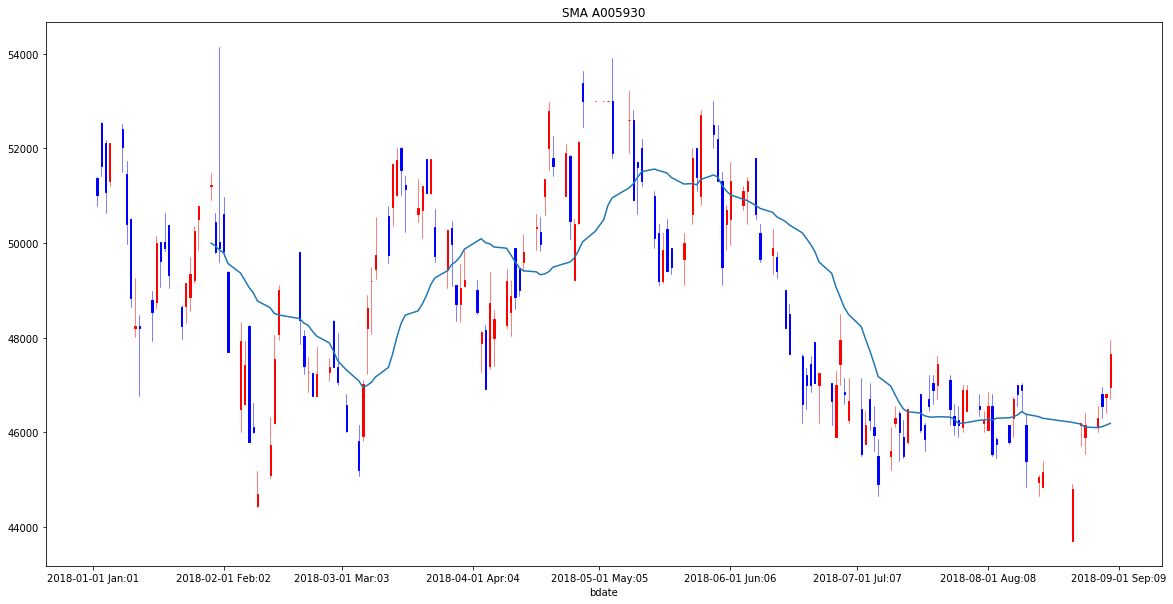

In [10]:
f1, ax = plt.subplots(1,1,figsize = (20,10))
ax.set_title('SMA A005930')
data['date'] = data.index.map(mdates.date2num)
candlestick_ohlc(ax, data[['date','open','high','low','close']].values, colorup='red',colordown='blue', width=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %h:%m'))
data['sma20'].plot()
plt.show()

# Exponential Moving Average
${ EMA }_{ t }(n)\quad =\quad \frac { \left( n+1 \right) { EMA }_{ t-1 }+{ Price }_{ t } }{ n+2 } $

In [11]:
data['ema20'] = talib.EMA(data['close'],20)

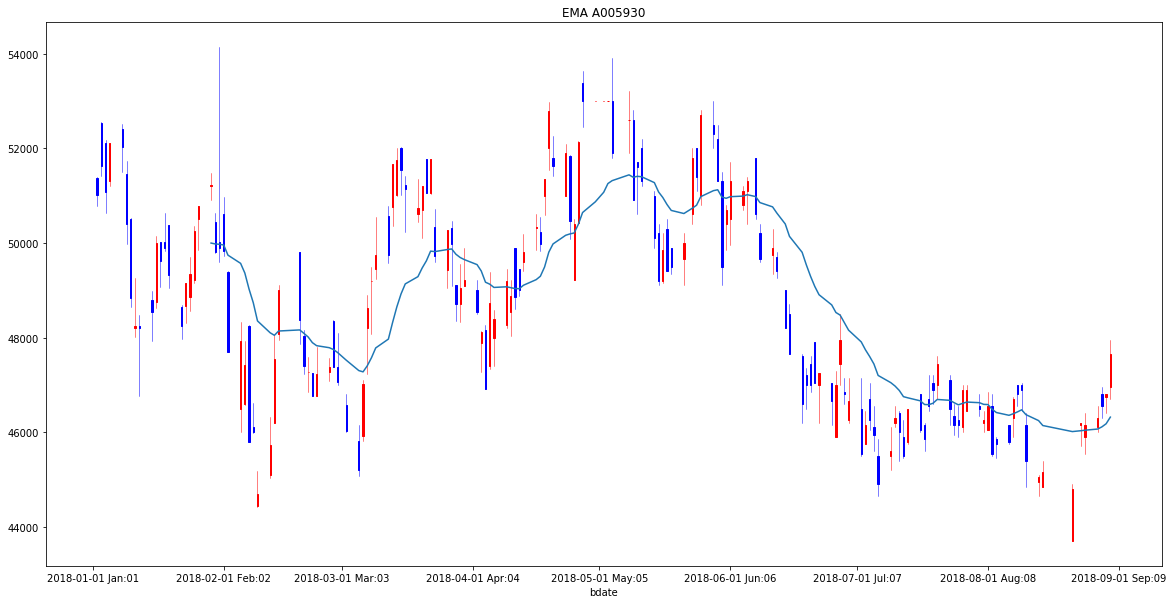

In [12]:
f1, ax = plt.subplots(1,1,figsize = (20,10))
ax.set_title('EMA A005930')
data['date'] = data.index.map(mdates.date2num)
candlestick_ohlc(ax, data[['date','open','high','low','close']].values, colorup='red',colordown='blue', width=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %h:%m'))
data['ema20'].plot()
plt.show()

# Moving Average Convergence and Divergence

${MACD \quad  Line} = {Short EMA} - {Long EMA} $

${MACD \quad  Signal \quad  Line} = {EMA \quad of  \quad MACD \quad  Line}$

In [22]:
data['macd']= talib.EMA(data['close'], 12) - talib.EMA(data['close'],26)
data['macd_signal'] = talib.EMA(data['macd'], 5)

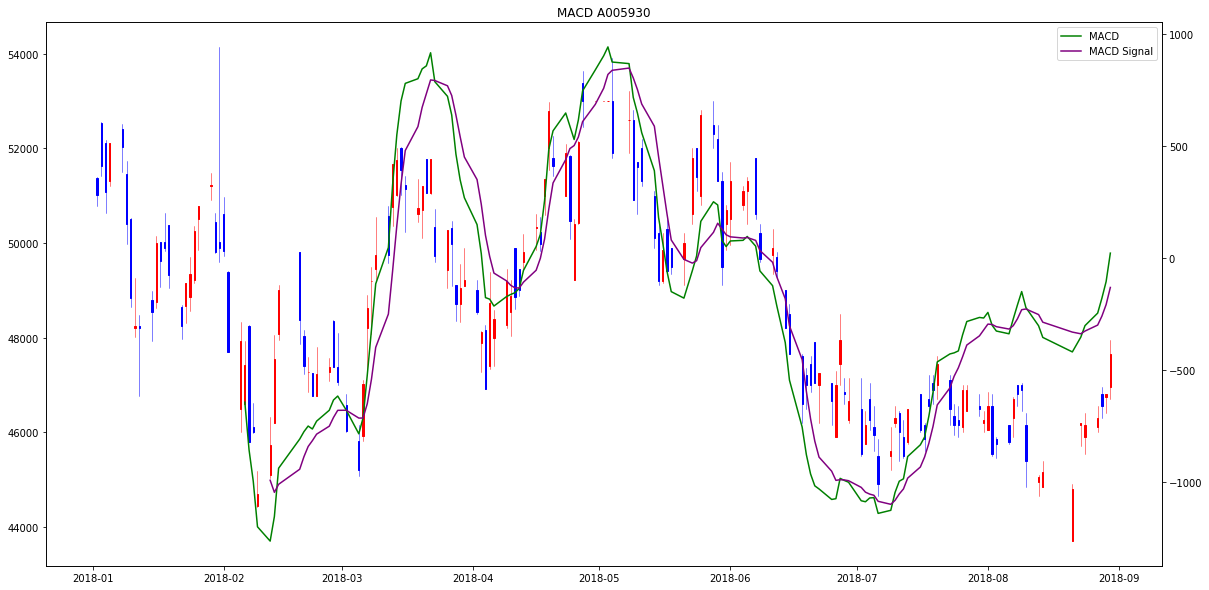

In [32]:
f1, ax = plt.subplots(1,1,figsize = (20,10) )
ax.set_title('MACD A005930')

data['date'] = data.index.map(mdates.date2num)
candlestick_ohlc(ax, data[['date','open','high','low','close']].values, colorup='red',colordown='blue', width=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %h:%m'))

ax2 = ax.twinx()
ax2.plot(data.index, data['macd'], label = 'MACD', color='g')
ax2.plot(data.index, data['macd_signal'], label = 'MACD Signal', color='purple')

plt.legend()
plt.show()

# Volume Weighted Moving Average
${ VWMA }_{ t }(n)\quad =\quad \frac { \sum _{ k=t-n+1 }^{ t }{ { Volume }_{ k }*{ Price }_{ k } }  }{ \sum _{ k=t-n+1 }^{ t }{ { Volume }_{ k } }  } $

In [13]:
###########################################################################
### Add pandas dataframe rolling functiong -> weighted rolling mean
from pandas.core.window import _flex_binary_moment, _Rolling_and_Expanding

def weighted_mean(self, weights, **kwargs):
    weights = self._shallow_copy(weights)
    window = self._get_window(weights)

    def _get_weighted_mean(X, Y):
        X = X.astype('float64')
        Y = Y.astype('float64')
        sum_f = lambda x: x.rolling(window, self.min_periods, center=self.center).sum(**kwargs)
        return sum_f(X * Y) / sum_f(Y)

    return _flex_binary_moment(self._selected_obj, weights._selected_obj,
                               _get_weighted_mean, pairwise=True)

_Rolling_and_Expanding.weighted_mean = weighted_mean


############################################################################

In [15]:
data['vwma20'] = data['close'].rolling(20).weighted_mean(data['volume'])

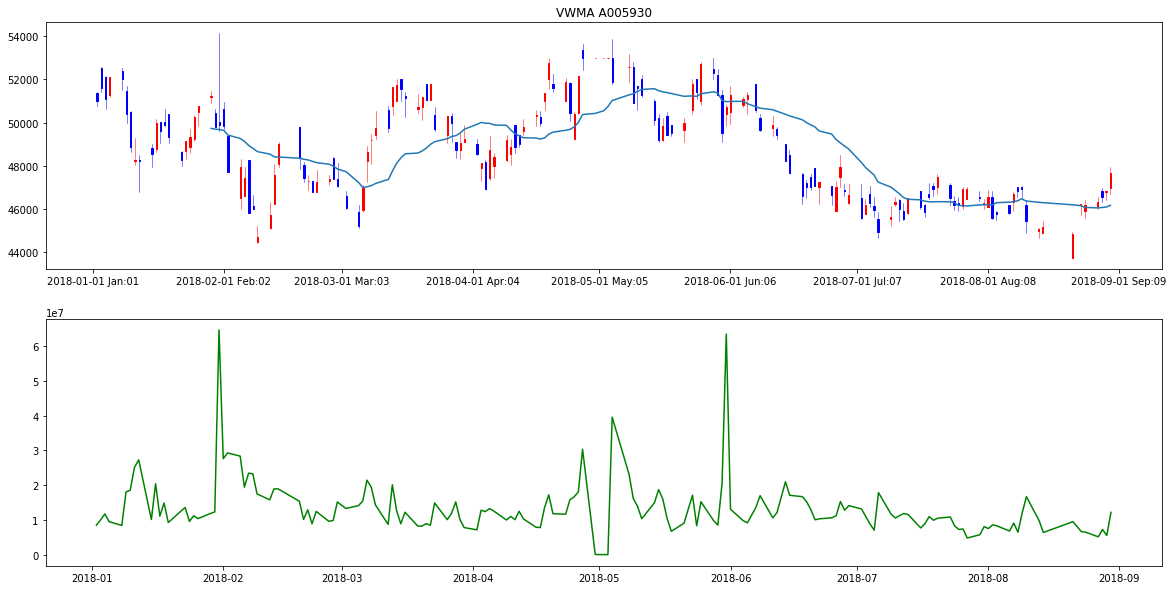

In [21]:
f1, (ax, ax1) = plt.subplots(2,1,figsize = (20,10))
ax.set_title('VWMA A005930')
data['date'] = data.index.map(mdates.date2num)
candlestick_ohlc(ax, data[['date','open','high','low','close']].values, colorup='red',colordown='blue', width=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %h:%m'))
ax.plot(data.index, data['vwma20'])
ax1.plot(data.index, data['volume'], label = 'Volume', color='g')
plt.show()

# Volume Weighted Moving Average Convergence and Divergence

${VW-MACD \quad  Line} = {Short VWMA} - {Long VWMA} $

${VW-MACD \quad  Signal \quad  Line} = {EMA \quad of  \quad MACD \quad  Line}$

In [33]:
data['vw-macd'] = data['close'].rolling(12).weighted_mean(data['volume']) - data['close'].rolling(26).weighted_mean(data['volume'])
data['vw-macd_signal'] = talib.EMA(data['vw-macd'], 5)

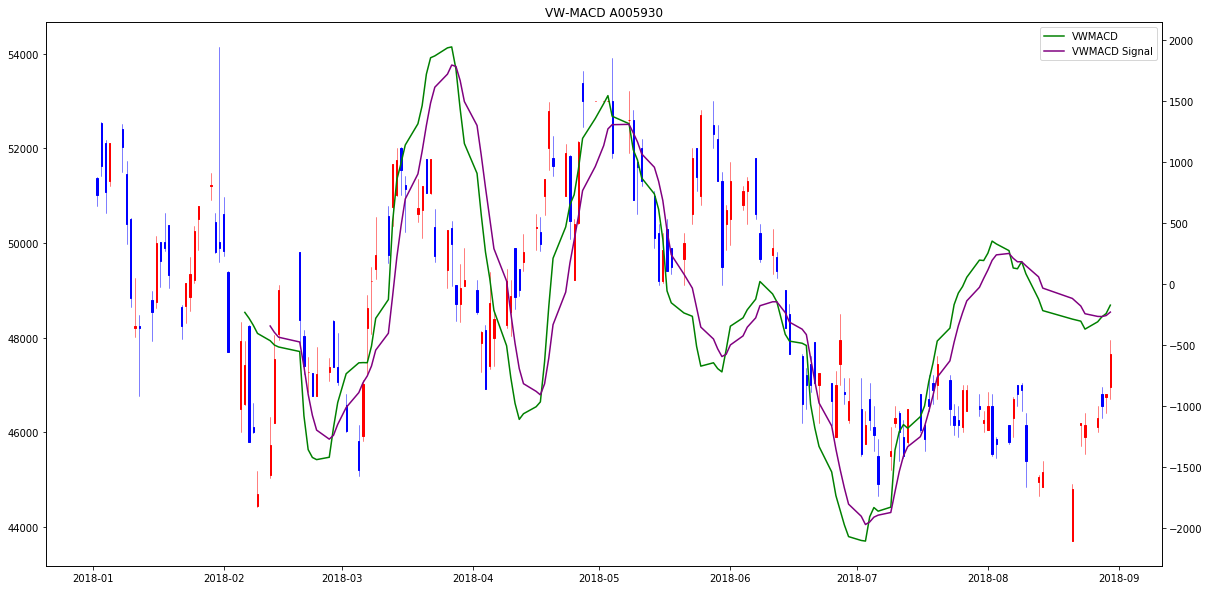

In [34]:
f1, ax = plt.subplots(1,1,figsize = (20,10) )
ax.set_title('VW-MACD A005930')

data['date'] = data.index.map(mdates.date2num)
candlestick_ohlc(ax, data[['date','open','high','low','close']].values, colorup='red',colordown='blue', width=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %h:%m'))

ax2 = ax.twinx()
ax2.plot(data.index, data['vw-macd'], label = 'VWMACD', color='g')
ax2.plot(data.index, data['vw-macd_signal'], label = 'VWMACD Signal', color='purple')

plt.legend()
plt.show()